In [11]:
# %%
from pathlib import Path 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from napatrackmater.Trackvector import (TrackVector,
                                        SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        
                                        )

In [21]:
dataset_name = 'Fifth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')
master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))

goblet_basal_radial_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}.csv')

save_dir = os.path.join(tracking_directory, f'neighbour_plots_predicted/')
Path(save_dir).mkdir(exist_ok=True, parents=True)

shape_cols = SHAPE_FEATURES
dynamic_cols = DYNAMIC_FEATURES
feature_cols = SHAPE_DYNAMIC_FEATURES

neighbour_radius_xy = 70 #pixels
neighbour_radius_z = 5


In [13]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax

tracks_goblet_basal_radial_dataframe = pd.read_csv(goblet_basal_radial_dataframe)

Reading Master XML


In [14]:
neighbour_dataframe = tracks_goblet_basal_radial_dataframe[~tracks_goblet_basal_radial_dataframe['Cell_Type'].isna()]

In [32]:



def find_neighbors_within_radius(df, radius_xy, height_z):
    neighbors_dict = {}
    unique_track_ids = df['Track ID'].unique()
    unique_time_points = df['t'].unique()
   
    for track_id in unique_track_ids:
        neighbors_dict[track_id] = {}
        
        for time_point in unique_time_points:
                valid_track_ids = []
                current_track = df[(df['Track ID'] == track_id) & (df['t'] == time_point)]
                if current_track.empty:
                   continue
                current_coords = current_track.iloc[0][['z', 'y', 'x']].values 
                time_filtered_df = df[df['t'] == time_point]
                for index, row in time_filtered_df.iterrows():
                     
                        distances_xy = np.sqrt((row['y'] - current_coords[1])**2 + 
                                            (row['x'] - current_coords[2])**2)
                        distances_z = np.abs(row['z'] - current_coords[0])
                        
                        within_radius_xy = distances_xy <= radius_xy
                        within_height_z = distances_z <= height_z
                        if within_radius_xy & within_height_z:
                              valid_track_ids.append(row['Track ID'])

                valid_track_ids = list(set(valid_track_ids))
                if track_id in valid_track_ids:
                   valid_track_ids.remove(track_id) 
                neighbor_cell_types = time_filtered_df[time_filtered_df['Track ID'].isin(valid_track_ids)]['Cell_Type'].tolist()
                neighbors_dict[track_id][time_point] = neighbor_cell_types
    
    return neighbors_dict

In [33]:
neighbors_dict = find_neighbors_within_radius(neighbour_dataframe, neighbour_radius_xy, neighbour_radius_z)

In [17]:

color_palette = {
    'Basal': '#1f77b4',  
    'Radial': '#ff7f0e',
    'Goblet': '#2ca02c',
}
def compute_for_timepoint(df,neighbors_dict, time_point):
    time_filtered_df = df[df['t'] == time_point]
    

    all_cell_type_types = {}
    for track_id in time_filtered_df['Track ID'].unique():
        track_data = time_filtered_df[time_filtered_df['Track ID'] == track_id].iloc[0]
        neighbors = neighbors_dict.get(track_id, {}).get(time_point, [])
        current_cell_type = track_data['Cell_Type']
        neighbor_counts = Counter(neighbors)
        if current_cell_type in all_cell_type_types:
           current_neighbour_counts = all_cell_type_types[current_cell_type] 
           neighbor_counts+=current_neighbour_counts
           all_cell_type_types[current_cell_type] = neighbor_counts
        else:
           all_cell_type_types[current_cell_type] = neighbor_counts    
    print(all_cell_type_types)   
       
    
    return all_cell_type_types

  
    

In [18]:
all_cell_type_types = compute_for_timepoint(neighbour_dataframe, neighbors_dict, 100)
all_cell_type_types

{'Basal': Counter({'Basal': 434, 'Radial': 12, 'Goblet': 7}), 'Radial': Counter({'Basal': 12, 'Goblet': 7, 'Radial': 6}), 'Goblet': Counter({'Goblet': 10, 'Radial': 7, 'Basal': 7})}


{'Basal': Counter({'Basal': 434, 'Radial': 12, 'Goblet': 7}),
 'Radial': Counter({'Basal': 12, 'Goblet': 7, 'Radial': 6}),
 'Goblet': Counter({'Goblet': 10, 'Radial': 7, 'Basal': 7})}

In [19]:
def plot_for_all_timepoints(df, neighbors_dict):
    timepoints = sorted(df['t'].unique())
    all_cell_type_types = {cell_type: {tp: Counter() for tp in timepoints} for cell_type in df['Cell_Type'].unique()}

    
    for time_point in timepoints:
        time_filtered_df = df[df['t'] == time_point]

        for track_id in time_filtered_df['Track ID'].unique():
            track_data = time_filtered_df[time_filtered_df['Track ID'] == track_id].iloc[0]
            current_cell_type = track_data['Cell_Type']
            neighbors = neighbors_dict.get(track_id, {}).get(time_point, [])
            neighbor_counts = Counter(neighbors)

            if current_cell_type in all_cell_type_types:
                all_cell_type_types[current_cell_type][time_point] += neighbor_counts
        
        
                
        
    
    fig, axs = plt.subplots(len(all_cell_type_types), 1, figsize=(16, len(all_cell_type_types) * 6))
    
    if len(all_cell_type_types) == 1:
        axs = [axs] 

   
    for idx, cell_type in enumerate(all_cell_type_types):
        ax = axs[idx]
        neighbor_types = sorted(set(neigh for counts in all_cell_type_types[cell_type].values() for neigh in counts))
        
        for neighbor in neighbor_types:
            y_values = [all_cell_type_types[cell_type][tp].get(neighbor, 0) for tp in timepoints]
            ax.plot(timepoints, y_values, label=f'{neighbor}', color=color_palette.get(neighbor, 'grey'), marker='o')

        ax.set_title(f'Neighbor Counts for Cell Type: {cell_type}')
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Count')
        ax.legend(loc='upper right')
        ax.grid(True)
    fig.savefig(os.path.join(save_dir, f'radius_{neighbour_radius_xy}_{neighbour_radius_z}_neighbor_counts.png'))
    plt.tight_layout()
    plt.show()

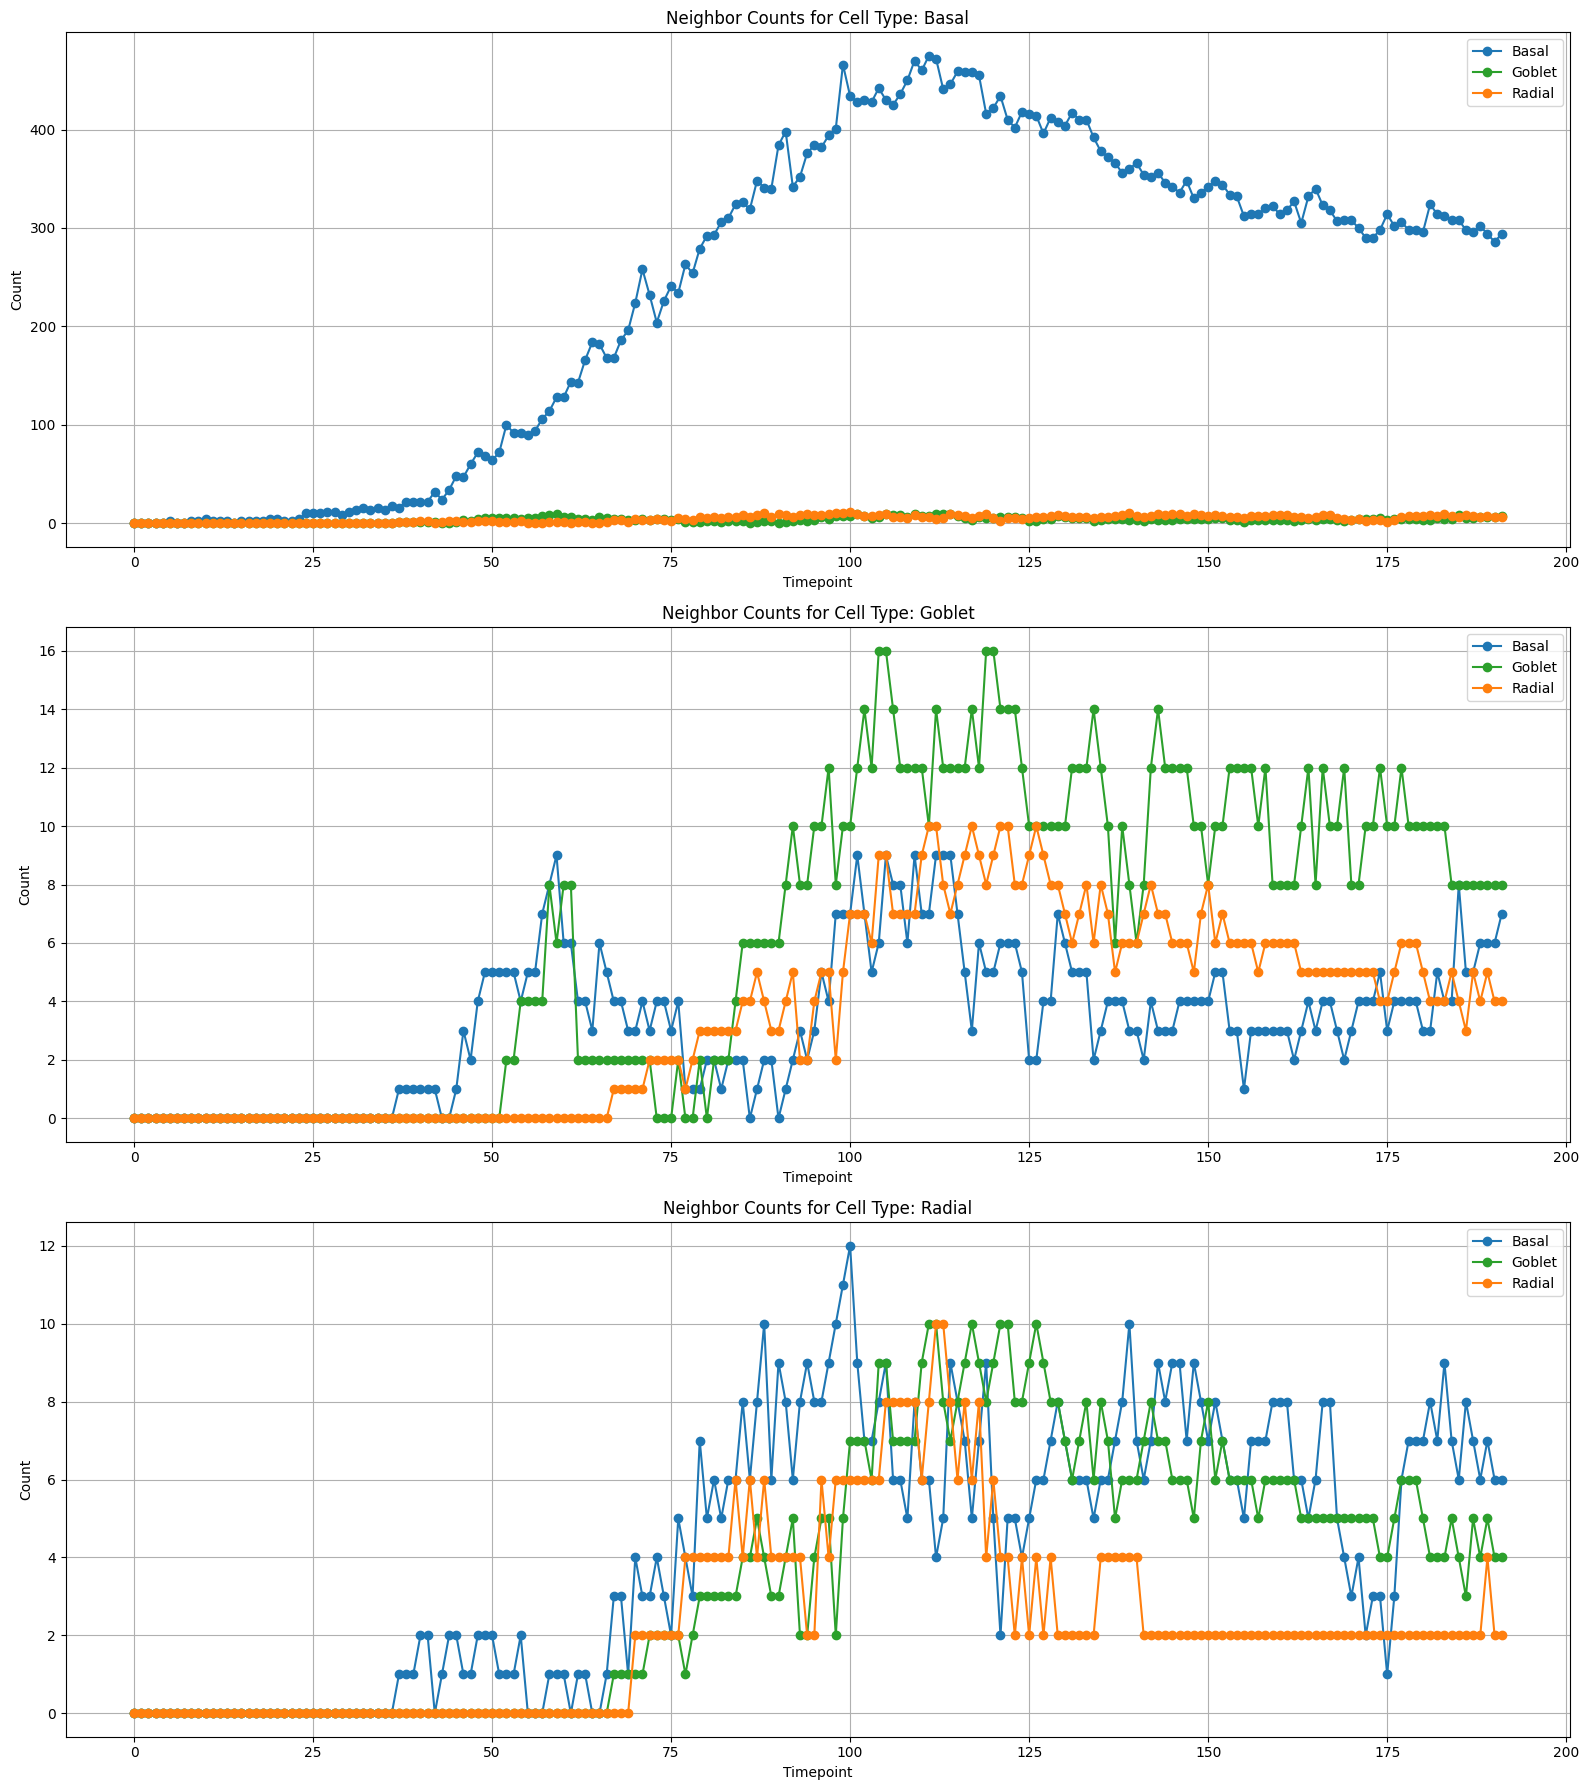

In [20]:
plot_for_all_timepoints(neighbour_dataframe, neighbors_dict)